<a href="https://colab.research.google.com/github/apd1995/Stats-203V-Introduction-to-Regression-Models-and-Analysis-of-Variance/blob/main/Stats_203V_Special_Topics_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These are notes created by Apratim Dey while he was an instructor of the course Stats 203V on Linear Models and Regression Analysis in Summer, 2023, at Stanford University. If these notes are helpful to you, please cite them appropriately. For any feedback, please open an issue on GitHub.



# Quantile Regression



Let us start with the Wage dataset available in the ISLR package in R. Run the following code chunk to get the dataset up on your working environment and get a sneak peek into the data.

In [1]:
install.packages('ISLR')
library(ISLR)
data("Wage")

# Preview the dataset
head(Wage)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.04315
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.47602
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.98218
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.68529
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.04315
376662,2008,54,2. Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,4.845098,127.11574


The dataset and variable names are self explanatory. As you can probably guess by the name of the dataset, the goal will be to predict $\verb|wage|$ (column 11) based on the other variables. And then one can ask relevant questions, such as, whether age has a significant impact on salary, or whether having a college degree really helps.

But first, let's look at the variable $\verb|wage|$.


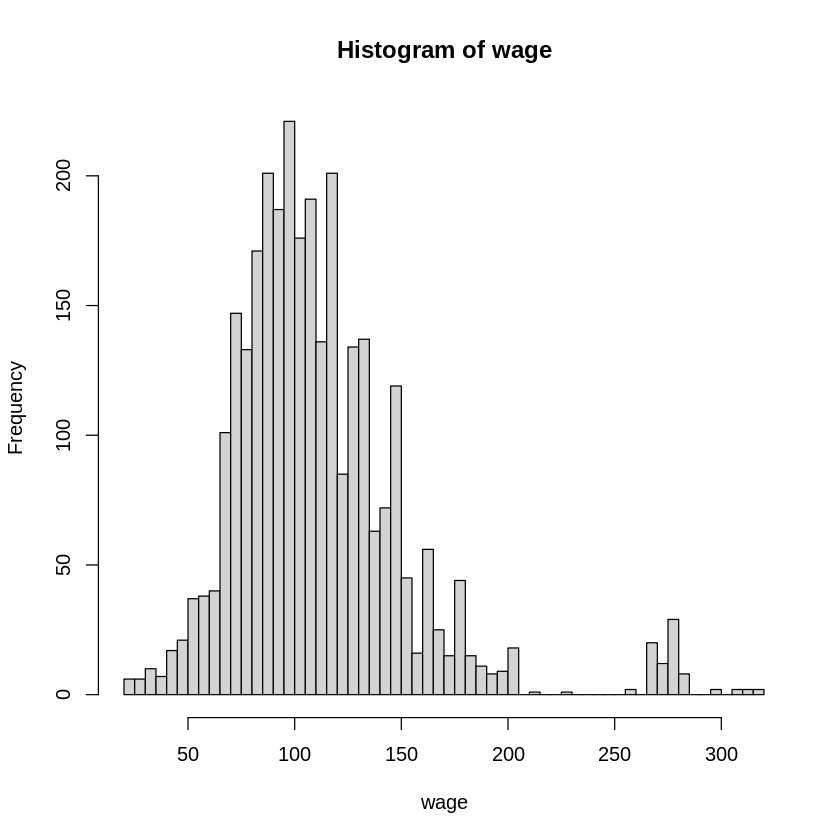

In [2]:
wage = Wage$wage

# Plot histogram
hist(wage, breaks = 50, xlab = "wage", main = "Histogram of wage")

We notice something interesting (and typical about wages). While the major chunk of people in the dataset seem to be earning wages below 150, there are a few (rich!) people earning above 250.

Let's do a density plot of the data, which will clarify this further.

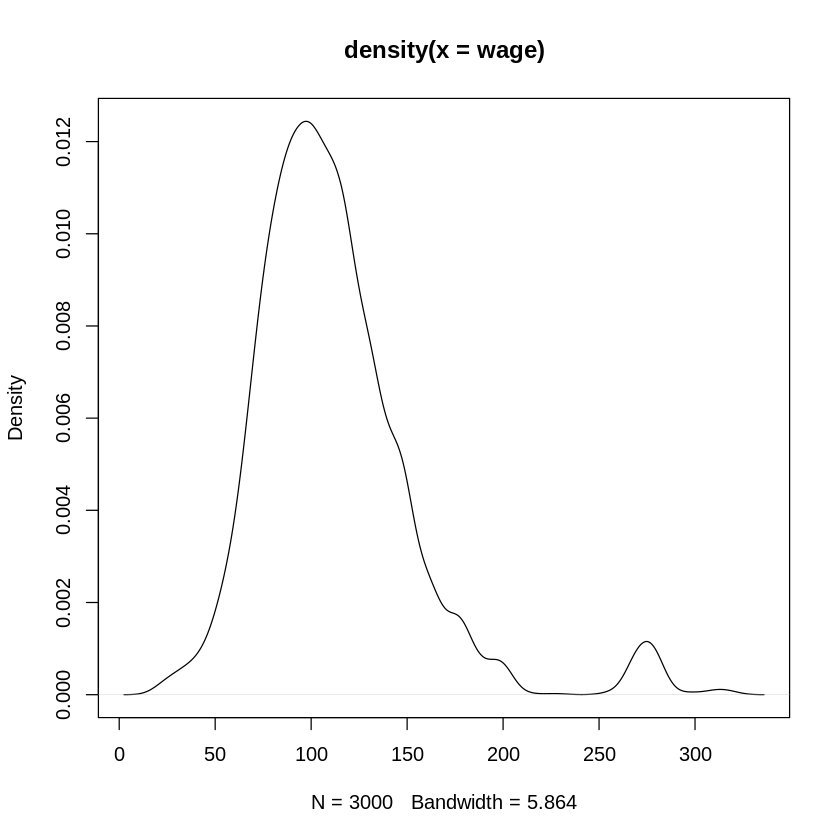

In [3]:
# Plot density of wage
plot(density(wage))

The $\verb|wage|$ values have a long tail, and we are looking at a real example of positively skewed data! The following boxplot also certifies this.

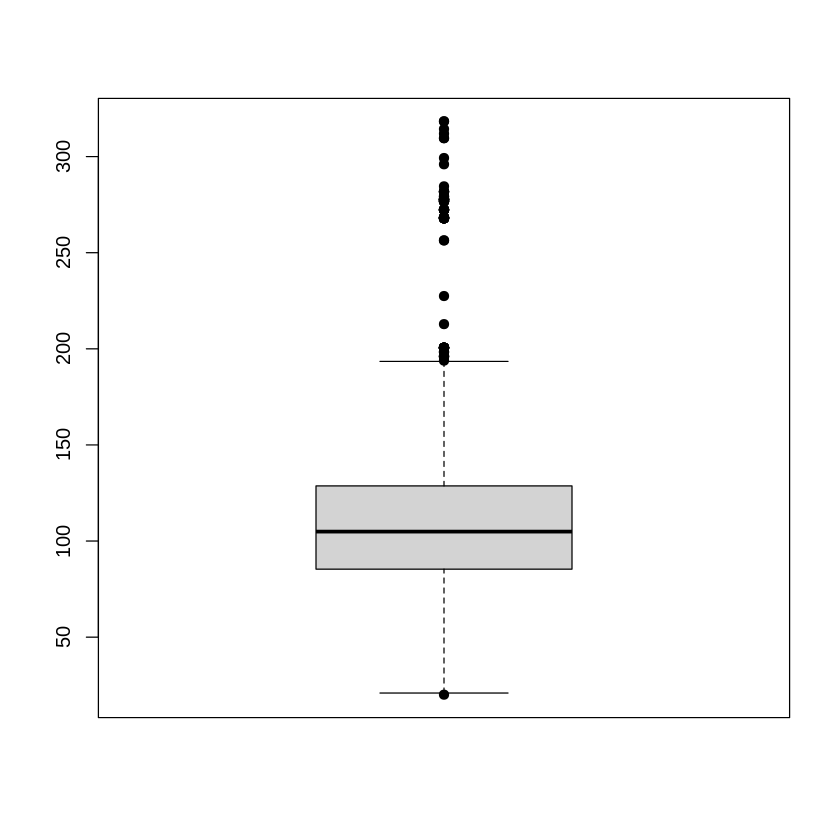

In [4]:
# Box and whisker plot of wage
boxplot(wage, pch = 19)

Let's see what fraction and number of people earn more than 250.

In [5]:
rich_frac = mean(wage > 250)
rich_count = sum(wage > 250)
c(round(rich_frac, 3), rich_count)

[1]  0.026 79.000

So, 79 people (about 2.6% of the sample) earn significantly more than the others in the dataset.

All these statistics tell us that the rich people constitute a sizeable minority, distinct from the rest of the people. This class is somewhat rare, and perhaps has its own characteristics.

Anyway, we would like to predict wages based on the other variables. But first, let us remove the variables $\verb|logwage|$ (as it is simply the log of the wage), $\verb|region|$ (as it is the same for everyone in the dataset) and $\verb|year|$.

In [6]:
# Let's rename the dataset to Wage_new after dropping the three columns
Wage_new = subset(Wage, select = -c(year, region, logwage))
head(Wage_new)

,age,maritl,race,education,jobclass,health,health_ins,wage
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
231655,18,1. Never Married,1. White,1. < HS Grad,1. Industrial,1. <=Good,2. No,75.04315
86582,24,1. Never Married,1. White,4. College Grad,2. Information,2. >=Very Good,2. No,70.47602
161300,45,2. Married,1. White,3. Some College,1. Industrial,1. <=Good,1. Yes,130.98218
155159,43,2. Married,3. Asian,4. College Grad,2. Information,2. >=Very Good,1. Yes,154.68529
11443,50,4. Divorced,1. White,2. HS Grad,2. Information,1. <=Good,1. Yes,75.04315
376662,54,2. Married,1. White,4. College Grad,2. Information,2. >=Very Good,1. Yes,127.11574


Notice that all the predictors (except age) are categorical. Let's build an ordinary linear regression model to predict wage now.

In [7]:
# Performing linear regression
reg_ols = lm(wage ~ ., data = Wage_new)
summary(reg_ols)


Call:
lm(formula = wage ~ ., data = Wage_new)

Residuals:
     Min       1Q   Median       3Q      Max 
-103.663  -18.706   -3.473   13.853  211.966 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  65.8356     3.5407  18.594  < 2e-16 ***
age                           0.2837     0.0623   4.554 5.47e-06 ***
maritl2. Married             16.9253     1.7234   9.821  < 2e-16 ***
maritl3. Widowed              0.9009     8.0206   0.112 0.910578    
maritl4. Divorced             3.6329     2.8929   1.256 0.209287    
maritl5. Separated           11.5439     4.8563   2.377 0.017512 *  
race2. Black                 -4.8977     2.1505  -2.277 0.022830 *  
race3. Asian                 -2.5041     2.6087  -0.960 0.337193    
race4. Other                 -5.9525     5.6809  -1.048 0.294809    
education2. HS Grad           7.8432     2.3754   3.302 0.000972 ***
education3. Some College     18.3040     2.5265   7.245 5.49e-13 ***
educat

Let's see how well the model has been able to fit the "rich" vs. the "bulk" class.

In [8]:
# Collect the indices corresponding to the "rich" class
rich_indices = which(Wage_new$wage > 250)

# Residuals on the rich and bulk classes
residuals_ols = reg_ols$residuals
residuals_ols_rich = residuals_ols[rich_indices]
residuals_ols_bulk = residuals_ols[-rich_indices]

# Mean wage predicted on the rich class
predicted_ols_rich_mean = mean(reg_ols$fitted.values[rich_indices])

# Output as data frame
data.frame(RMSE_bulk = sqrt(mean(residuals_ols_bulk^2)),
RMSE_rich = sqrt(mean(residuals_ols_rich^2)),
predicted_rich_mean = predicted_ols_rich_mean,
actual_rich_mean = mean(wage[rich_indices]))

RMSE_bulk,RMSE_rich,predicted_rich_mean,actual_rich_mean
<dbl>,<dbl>,<dbl>,<dbl>
25.89426,138.197,141.7206,277.5325


Notice how drastically worse the model has performed on the rich class.

This is not unexpected; this is precisely due to the rarity of the rich class. The model we built tries to fit the "bulk" or the majority. It does not do well for the rich group which constitutes a higher quantile of $\verb|wage|$. If we want to understand the rich community better, this general model  will not be good enough.

So, what do we do? Do we simply ignore the rest of the data and fit a model restricted only to the rich class? This approach would suffer from a higher variance as it wouldn't be able to leverage shared information across the full population.

Here is where quantile regression comes in. It aims to fit the higher quantiles of the dataset (and not just the mean, which ordinary linear models do). As a result, it takes into account the full dataset.

Let's first see the performance of quantile regression on this dataset. It can be implemented using the $\verb|rq|$ function in $\verb|quantreg|$ package in R.

In [9]:
install.packages("quantreg")
library(quantreg)

# Fit quantile regression to 97.4th quantile (top 2.6%)
reg_quant = rq(wage ~ ., tau = 0.974, data = Wage_new)
reg_quant

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SparseM’, ‘MatrixModels’


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve




Call:
rq(formula = wage ~ ., tau = 0.974, data = Wage_new)

Coefficients:
                (Intercept)                         age 
                 88.6968222                   0.3662265 
           maritl2. Married            maritl3. Widowed 
                 30.2640008                   3.1350188 
          maritl4. Divorced          maritl5. Separated 
                 13.4242355                  19.6434331 
               race2. Black                race3. Asian 
                 -0.8862094                  -9.2379401 
               race4. Other         education2. HS Grad 
                  4.2609114                  13.5172467 
   education3. Some College    education4. College Grad 
                 29.2824640                 116.8968408 
education5. Advanced Degree      jobclass2. Information 
                134.1207849                   5.1271706 
       health2. >=Very Good             health_ins2. No 
                 10.4350399                 -13.3799595 

Degrees of fr

We can simultaneously fit quantile regression to a grid of chosen quantiles without any extra effort. We simply add those quantiles as an array.

In [10]:
# Fit quantile regression to the 50th, 97.4th, 98th and 99th percentiles
rq(wage ~ ., data = Wage_new, tau = c(0.5, 0.974, 0.98, 0.99))

Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”


Call:
rq(formula = wage ~ ., tau = c(0.5, 0.974, 0.98, 0.99), data = Wage_new)

Coefficients:
                             tau= 0.500  tau= 0.974  tau= 0.980  tau= 0.990
(Intercept)                  66.3603204  88.6968222  89.4978924  80.1627869
age                           0.2576069   0.3662265   0.2682472   0.9359593
maritl2. Married             15.0390531  30.2640008  34.6684777  24.0041860
maritl3. Widowed             11.0386323   3.1350188   2.6033084 -29.4213087
maritl4. Divorced             5.3759808  13.4242355  16.8944832  15.2285327
maritl5. Separated           11.5310282  19.6434331  20.4746424   5.1114545
race2. Black                 -5.1569415  -0.8862094   5.2530606  55.6029315
race3. Asian                 -2.3420308  -9.2379401 -11.7276892  15.6741952
race4. Other                 -2.4400437   4.2609114  -2.2821046 -14.6082137
education2. HS Grad           7.9675465  13.5172467  18.2005946  15.4049936
education3. Some College     19.2333798  29.2824640  37.8658101  90.06

Observe how the top quantiles are different from the median, say. For the median person, an advanced degree seems to provide much less benefit than what it provides for the top rich. The 99th percentile wages seem to be adversely affected if the person is widowed, but the lower percentiles are positively affected in the same case.

Now let us look at the coefficient estimates for the ordinary regression and quantile regression for the median.

In [11]:
reg_quant_median = rq(wage ~ ., tau = 0.5, data = Wage_new)

data.frame(quantile_regression_coefs = reg_quant_median$coefficients,
ols_coefs = reg_ols$coefficients)

Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”


,quantile_regression_coefs,ols_coefs
,<dbl>,<dbl>
(Intercept),66.3603204,65.8356308
age,0.2576069,0.2837375
maritl2. Married,15.0390531,16.9252718
maritl3. Widowed,11.0386323,0.9008732
maritl4. Divorced,5.3759808,3.6328737
maritl5. Separated,11.5310282,11.5439422
race2. Black,-5.1569415,-4.8977143
race3. Asian,-2.3420308,-2.5040783
race4. Other,-2.4400437,-5.9525439


The estimates are not too different, suggesting that indeed the ordinary least squares regression was explaining the "average" or "median" individual in our dataset.

Now, let's see how well the quantile regression model built on the 98th percentile performs in predicting the top quantiles.

In [12]:
# Perform quantile regression on 98th percentile
reg_quant_top = rq(wage ~ ., tau = 0.98, data = Wage_new)

# Get the residuals on the "rich" people and compute RMSE
residuals_quant_rich = reg_quant_top$residuals[rich_indices]
RMSE_quant_rich = sqrt(mean(residuals_quant_rich^2))

# Output data frame to compare with old RMSE from OLS
data.frame(RMSE_quant_rich = RMSE_quant_rich, RMSE_ols_rich = sqrt(mean(residuals_ols_rich^2)))

RMSE_quant_rich,RMSE_ols_rich
<dbl>,<dbl>
49.39083,138.197


Observe how the RMSE has gone down significantly. We can also compare the average prediction.

In [13]:
data.frame(predicted_quant_rich_mean = mean(reg_quant_top$fitted.values[rich_indices]),
predicted_old_rich_mean = predicted_ols_rich_mean,
true_old_rich_mean = mean(wage[rich_indices]))

predicted_quant_rich_mean,predicted_old_rich_mean,true_old_rich_mean
<dbl>,<dbl>,<dbl>
261.1409,141.7206,277.5325


Notice the improvement here as well.

It is important to remember though that the results of quantile regression will typically depend on the quantiles/ percentiles we choose to fit. If we are interested in modeling the 98th percentile, we would use the corresponding quantile regression, which may not give a good answer at another percentile, say, 50%.

The whole idea behind quantile regression is that one single global regression model describing the mean behavior of data may not be enough in many applications. A better idea is to model instead the various quantiles. Different quantiles may depend differently on the predictors, and this stratification provides useful information in decision making process.

## Technical words...

Now that we have talked about quantile regression through a data example, let's say a word or two about what it is doing, mathematically.

Ordinary linear regression minimizes the sum of squared errors: $\sum_{i=1}^n (y_i - x_i'\beta)^2$. The loss involved is the squared error loss.

Quantile regression uses a different loss function - the *check* loss. One can show that minimizing the check loss for a given percentile gives the corresponding quantile.